# P1
### Arthur Bright
- project refined,

-- suggest a "minimum viable product", a baseline project

-- suggest how project will be evaluated (what methods you will use, what data you will use, etc.)  At this point you get to set the rules.  Again, you are establishing what you will do to "complete" the project.

-- provide any stretch goals.


- show current progress, any of the following:

--> project refinement

--> additional citations (paper, data, video links)

--> plots of data collected or generated (you can begin exploration in

        Audacity, Friture spectrum/waveform analyzer, or anything else)

        choosing data representative of what you are working with

--> algorithms run on any data, "working" or not.

--> use of web-based algorithms, collection of results


# Imports

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
import sounddevice as sd
from scipy import signal

# Representation of Sung Notes

In [52]:
# Convert a piano note's index into a frequency (using equal temperament)
#eg A0 = 0, A#0 = 1, etc
def piano(ind: int):
    assert(isinstance(ind, int))
    assert(ind >= 0)
    # using A4 = 440, we have A0 = 440/16 = 27.5
    return 27.5 * (2**(ind/12))

# A class to represent a frequency, but can be instantiated using a piano note index as well.
class Freq:
    def __init__(self, freq):
        assert(isinstance(freq, float) or isinstance(freq, int))
        assert(freq > 0)
        self.v = float(freq)

    def __str__(self):
        return str(self.v)


# A class to represent a phoneme. Currently only supports a subset of japanese language
class Phoneme:
    consonants =   ["k", "g", "s", "z", "t", "d", "n", "h", "b", "p", "m", "r", "w", "j"]
    plosives =     ["p", "t", "b", "d", "g", "k"]
    fricatives =   ["s", "z", "h"]
    nasals =       ["m", "n"]
    approximants = ["w", "r", "j"]
    assert((set(plosives) | set(fricatives) | set(nasals) | set(approximants)) == set(consonants))

    vowels =       ["a", "o", "u", "i", "e"]

    def __init__(self, s: str):
        assert(s in self.consonants or s in self.vowels)
        self.v = s

    def __str__(self):
        return str(self.v)


# A class to represent a syllable. Captures a consonant + vowel OR lone vowel
class Syllable:
    def __init__(self, vowel: Phoneme, cons: Phoneme = None):
        assert(isinstance(vowel, Phoneme))
        assert(vowel.v in Phoneme.vowels)
        if (cons is not None):
            assert(isinstance(cons, Phoneme))
            assert(cons.v in Phoneme.consonants)
        self.vowel = vowel
        self.cons = cons

    def __str__(self):
        if(self.cons):
            return str(self.cons) + str(self.vowel)
        return str(self.vowel)
    
    def of_str(s : str):
        if len(s) == 1:
            return Syllable(vowel=Phoneme(s))
        elif len(s) == 2:
            return Syllable(vowel=Phoneme(s[1]), cons=Phoneme(s[0]))
        else:
            return ValueError(f"Illegal representation of syllable: {str(s)}")

# A class to represent a sung note, which includes a (fundamental) frequency, syllable, and duration.
class Note:
    def __init__(self, f : Freq, s: Syllable, duration: float):
        assert(isinstance(f, Freq) and isinstance(s, Syllable) and isinstance(duration, float))
        self.f = f
        self.s = s
        self.duration = duration

    def __str__(self):
        return f"[{str(self.s)}|{str(self.f)}|{str(self.duration)}]"

# A class to represent a period of silence.
class Silence:
    def __init__(self, duration: float):
        assert(isinstance(duration, float))
        self.duration = duration

    def __str__(self):
        return f"[Silence {str(self.duration)}]"
    

In [ ]:
# TESTER CODE
_f1 = Freq(piano(48))
print(_f1)

_p1 = Phoneme('a')
_p2 = Phoneme('b')
print(_p1)

_s1 = Syllable(_p1, _p2)
print(_s1)

_n1 = Note(_f1, _s1, 1.0)
print(_n1)

_sil1 = Silence(1.0)
print(_sil1)

440.0
a
ba
[ba|440.0|1.0]
[Silence 1.0]


# Interface to Convert Sung Notes to Signal

#### Converting to/from files, and sonification/visualization

In [ ]:
# helpers to play/write/read audio
fs=44100

def play_audio(y):
    sd.play(y,fs)

def write_audio(y, filename):
    sf.write(filename+'.wav',y,fs)

def read_audio(filename):
    return sf.read(filename +'.wav')

def graph_signal(y, start=None, end=None):    
    plt.figure()
    x = np.arange(len(y))/fs
    plt.plot(x, y)
    plt.xlim(start, end)


#### Simple Synthesizer

In [104]:
# synthesizer (similar to A2)
def simple_synth(f1: Freq, a, phi, T:float):
    if not isinstance(a, list):  a = [a]
    if not isinstance(phi, list):  phi = [phi]
    assert(len(a) == len(phi))

    # TODO: rounding; loses information
    N=int(T*fs)
    t=np.arange(N)/fs

    y = np.zeros_like(t)
    base = f1.v
    for i in range(len(a)):
        f = (i + 1) * base
        y2 = a[i] * np.cos(2*np.pi*f*t + phi[i])
        y += y2

    return y


#### Convert notes to signal

In [49]:
def convert_note_primitive(note: Note):
    # if silence, return 0s
    if isinstance(note, Silence):
        # TODO: rounding: loses information
        N = int(note.duration * fs)
        return np.zeros(N)
    else:
        f = note.f
        s = note.s
        duration = note.duration

        return simple_synth(f, [1.0], 0, duration)

In [40]:
# simply concatenate synthesized notes (very primitive)
def convert_notes_primitive(notes: list):
    y = np.array([])
    for note in notes:
        y = np.concatenate((y, convert_note_primitive(note)))
    return y

In [ ]:
# Driver code
_dur = 0.2
notes = [
    Note(Freq(piano(48)), Syllable.of_str('a'), _dur),
    Note(Freq(piano(46)), Syllable.of_str('a'), _dur),
    Note(Freq(piano(44)), Syllable.of_str('a'), _dur),
    Silence(_dur),
    Note(Freq(piano(46)), Syllable.of_str('a'), _dur),
    Note(Freq(piano(48)), Syllable.of_str('a'), _dur)
]

y = convert_notes_primitive(notes)
play_audio(y)



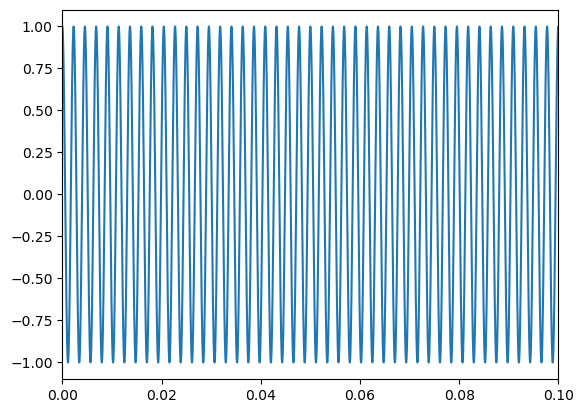

In [111]:
graph_signal(y, 0, 0.1)
